### Data Science/Analytics Exercise Brief

On Kaggle you will find a Home Insurance dataset covering 2007 – 2012 policies for a home insurance company representative of customers looking for a quote on their home policy. Using Python, explore and analyse this dataset. As part of the EDA process, profile the customer base drawing out any interesting information about them, in order to then build a predictive model which helps to predict who would be best to target to reduce the number of future lapsed cases.

You may use whichever techniques, or algorithm(s), you find most appropriate to tackle this task.  You will present a summary of your work, again in whatever format you want, for no longer than 30 minutes at interview, with a further 30 minutes for questions.

Areas which you should pay particular attention to are;
- Data exploration: What are the most interesting features of the data set? What have you considered and why have you made the decisions you have done? How are customers differentiated and what are the relationships between them and lapsed cases.
- Modelling: What process did you follow when modelling?  How have you designed your model and what did you account for?
- What are your conclusions, proposed next steps and what else would’ve been useful to know? What would you recommend to the business in terms of targeting to reduce churn?

Bear in mind that you will only have 30 minutes of presentation time so being succinct is important. We ask that you provide both your code and your final materials you will present the day before your interview date. Please email your submission to Georgia Harris before then.


### Import packages

##### NB. To run this notebook, please load within the working directory "esure", so that packages are imported successfully via relative paths  

In [1]:
# Standard modules
import os
import pandas as pd
import sys
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Custom modules
from utils import get_feature_types, select_dummy_values, dummy_encode_dataframe
from eda.fig_func import (
    bar_figure, bar_diff_figure, plot_dist, plot_box, plot_cat_bar, n_cat_fun, plot_cat_bar
)
from models.xgb_params import xgb_model_paras_feature_sel
from performance.metrics import (
    result_build,performance_metric, get_confusion_matrix, get_distributions, auc_plot
)
from performance.business_fig_func import (
    ProbaDist, FeatureImportance, UpliftChart
)

# 1) Initial data inspection

### a) Loading and visualising as pandas dataframe

In [2]:
df = pd.read_csv("datasets/home_insurance.csv")

In [3]:
df.head(100)

,QUOTE_DATE,COVER_START,CLAIM3YEARS,P1_EMP_STATUS,P1_PT_EMP_STATUS,BUS_USE,CLERICAL,AD_BUILDINGS,RISK_RATED_AREA_B,SUM_INSURED_BUILDINGS,...,HP3_ADDON_PRE_REN,HP3_ADDON_POST_REN,MTA_FLAG,MTA_FAP,MTA_APRP,MTA_DATE,LAST_ANN_PREM_GROSS,POL_STATUS,i,Police
0,11/22/2007,22/11/2007,N,R,NaN,N,NaN,Y,19.0,1000000.0,...,N,N,N,NaN,NaN,NaN,274.81,Lapsed,1,P000001
1,11/22/2007,01/01/2008,N,E,NaN,Y,N,Y,25.0,1000000.0,...,N,N,Y,308.83,-9.27,NaN,308.83,Live,2,P000002
2,11/23/2007,23/11/2007,N,E,NaN,N,NaN,N,NaN,0.0,...,N,N,Y,52.65,52.65,03/11/2010,52.65,Live,3,P000003
3,11/23/2007,12/12/2007,N,R,NaN,N,NaN,N,NaN,0.0,...,N,N,N,NaN,NaN,NaN,54.23,Live,4,P000004
4,11/22/2007,15/12/2007,N,R,NaN,N,NaN,Y,5.0,1000000.0,...,N,N,N,NaN,NaN,NaN,244.58,Live,5,P000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10/18/2007,20/11/2007,N,R,NaN,N,NaN,Y,12.0,1000000.0,...,N,N,N,NaN,NaN,NaN,139.92,Lapsed,96,P000096
96,7/27/2007,08/11/2007,N,R,NaN,N,NaN,Y,0.0,1000000.0,...,N,N,N,NaN,NaN,NaN,245.50,Live,97,P000097
97,10/22/2007,07/11/2007,N,E,NaN,N,NaN,Y,14.0,1000000.0,...,N,N,Y,246.64,246.64,06/12/2007,246.64,Live,98,P000098
98,10/15/2007,05/11/2007,N,E,NaN,N,NaN,Y,7.0,1000000.0,...,N,N,N,NaN,NaN,NaN,240.86,Lapsed,99,P000099


####  Column definitions
QUOTE_DATE: Day where the quotation was made

COVER_START: Beginning of the cover payment

CLAIM3YEARS: 3 last years loss

P1_EMP_STATUS: Client's professional status

P1_PT_EMP_STATUS: Client's part-time professional status

BUS_USE: Commercial use indicator

CLERICAL: Administration office usage indicator

AD_BUILDINGS: Building coverage - Self damage

RISK_RATED_AREA_B: Geographical Classification of Risk - Building

SUM_INSURED_BUILDINGS: Assured Sum - Building

NCD_GRANTED_YEARS_B: Bonus Malus - Building

AD_CONTENTS: Coverage of personal items - Self Damage

RISK_RATED_AREA_C: Geographical Classification of Risk - Personal Objects

SUM_INSURED_CONTENTS: Assured Sum - Personal Items

NCD_GRANTED_YEARS_C: Malus Bonus - Personal Items

CONTENTS_COVER: Coverage - Personal Objects indicator

BUILDINGS_COVER: Cover - Building indicator

SPEC_SUM_INSURED: Assured Sum - Valuable Personal Property

SPEC_ITEM_PREM: Premium - Personal valuable items

UNSPEC_HRP_PREM: Unknown

P1_DOB: Date of birth of the client

P1_MAR_STATUS: Marital status of the client

P1_POLICY_REFUSED: Police Emission Denial Indicator

P1_SEX: customer sex

APPR_ALARM: Appropriate alarm

APPR_LOCKS: Appropriate lock

BEDROOMS: Number of bedrooms

ROOF_CONSTRUCTION: Code of the type of construction of the roof

WALL_CONSTRUCTION: Code of the type of wall construction

FLOODING: House susceptible to floods

LISTED: National Heritage Building

MAX_DAYS_UNOCC: Number of days unoccupied

NEIGH_WATCH: Vigils of proximity present

OCC_STATUS: Occupancy status

OWNERSHIP_TYPE: Type of membership

PAYING_GUESTS: Presence of paying guests

PROP_TYPE: Type of property

SAFE_INSTALLED: Safe installs

SEC_DISC_REQ: Reduction of premium for security

SUBSIDENCE: Subsidence indicator (relative downwards motion of the surface )

YEARBUILT: Year of construction

CAMPAIGN_DESC: Description of the marketing campaign

PAYMENT_METHOD: Method of payment

PAYMENT_FREQUENCY: Frequency of payment

LEGAL_ADDON_PRE_REN: Option "Legal Fees" included before 1st renewal

LEGAL_ADDON_POST_REN: Option "Legal Fees" included after 1st renewal

HOME_EM_ADDON_PRE_REN: "Emergencies" option included before 1st renewal

HOME_EM_ADDON_POST_REN: Option "Emergencies" included after 1st renewal

GARDEN_ADDON_PRE_REN: Option "Gardens" included before 1st renewal

GARDEN_ADDON_POST_REN: Option "Gardens" included after 1st renewal

KEYCARE_ADDON_PRE_REN: Option "Replacement of keys" included before 1st renewal

KEYCARE_ADDON_POST_REN: Option "Replacement of keys" included after 1st renewal

HP1_ADDON_PRE_REN: Option "HP1" included before 1st renewal

HP1_ADDON_POST_REN: Option "HP1" included after 1st renewal

HP2_ADDON_PRE_REN: Option "HP2" included before 1st renewal

HP2_ADDON_POST_REN: Option "HP2" included afterrenewal

HP3_ADDON_PRE_REN: Option "HP3" included before 1st renewal

HP3_ADDON_POST_REN: Option "HP3" included after renewal

MTA_FLAG: Mid-Term Adjustment indicator

MTA_FAP: Bonus up to date of Adjustment

MTA_APRP: Adjustment of the premium for Mid-Term Adjustmen

MTA_DATE: Date of Mid-Term Adjustment

LAST_ANN_PREM_GROSS: Premium - Total for the previous year

POL_STATUS: Police status

Police: Police number


---
From initial observations on the data, we can immediately identify:
- "index columns", i.e. customer or policy descriptors which are unique for each dataframe record
- a "target column" from which we can generate our initial target variable (pending further inspection)

### b) Determining initial target variables, index columns and features

In [4]:
index_cols = ["i", "Police"]
target = "POL_STATUS"

df_index_cols = df[index_cols]
df_target = df[target]

In [5]:
# Remove the index columns but save them for later stitching (to selecet final audience)
df_with_index = df.copy()

df = df_with_index.drop(index_cols, axis = 1)

### c) Engineering the target variable
We will use the context of our task to refine the target variable that we are predicting 

In [6]:
# Print the proportions of each category in the initial target variables
df.groupby(target).size()

POL_STATUS
Cancelled      4311
Lapsed        52534
Live         132160
Unknown          16
dtype: int64

In [7]:
# Since there are some records with null or "Unknown" policy status, they can be removed
df[target].fillna("Unknown", inplace = True)
df = df[df[target] != "Unknown"]

NB: Cancelled policies could be treated differently. Usually, "lapsed" policies refer to lapse at a renewal date, whereas cancellation could include mid-term cancellation. Here se will simply consider "cancelled" policies as lapsed policies, since they are not "live"

In [8]:
df[target] = df[target].replace("Cancelled", "Lapsed")

In [9]:
# Cast "live" and "lapse" targets as binary integers for ease in modelling
df[target] = df[target].replace("Lapsed", 1)
df[target] = df[target].replace("Live", 0)
df[target] = df[target].astype(int)

### d) Inspecting datatypes to bucket features into numerical and categorical features
Machine learning models often require features data to be passed into specific datatypes. Here we attempt to simply datatypes for all our features (not index cols or target col) into two buckets, "categorical" and "numeric"

In [10]:
df.drop(target, axis = 1).dtypes.value_counts()

object     40
float64    23
dtype: int64

In [11]:
df.dtypes

QUOTE_DATE              object
COVER_START             object
CLAIM3YEARS             object
P1_EMP_STATUS           object
P1_PT_EMP_STATUS        object
                        ...   
MTA_FAP                float64
MTA_APRP               float64
MTA_DATE                object
LAST_ANN_PREM_GROSS    float64
POL_STATUS               int32
Length: 64, dtype: object

In [12]:
feature_types = get_feature_types(df.drop(target, axis = 1))
feature_types

{'numeric': ['RISK_RATED_AREA_B',
  'SUM_INSURED_BUILDINGS',
  'NCD_GRANTED_YEARS_B',
  'RISK_RATED_AREA_C',
  'SUM_INSURED_CONTENTS',
  'NCD_GRANTED_YEARS_C',
  'SPEC_SUM_INSURED',
  'SPEC_ITEM_PREM',
  'UNSPEC_HRP_PREM',
  'BEDROOMS',
  'ROOF_CONSTRUCTION',
  'WALL_CONSTRUCTION',
  'LISTED',
  'MAX_DAYS_UNOCC',
  'OWNERSHIP_TYPE',
  'PAYING_GUESTS',
  'PROP_TYPE',
  'YEARBUILT',
  'CAMPAIGN_DESC',
  'PAYMENT_FREQUENCY',
  'MTA_FAP',
  'MTA_APRP',
  'LAST_ANN_PREM_GROSS'],
 'categorical': ['QUOTE_DATE',
  'COVER_START',
  'CLAIM3YEARS',
  'P1_EMP_STATUS',
  'P1_PT_EMP_STATUS',
  'BUS_USE',
  'CLERICAL',
  'AD_BUILDINGS',
  'AD_CONTENTS',
  'CONTENTS_COVER',
  'BUILDINGS_COVER',
  'P1_DOB',
  'P1_MAR_STATUS',
  'P1_POLICY_REFUSED',
  'P1_SEX',
  'APPR_ALARM',
  'APPR_LOCKS',
  'FLOODING',
  'NEIGH_WATCH',
  'OCC_STATUS',
  'SAFE_INSTALLED',
  'SEC_DISC_REQ',
  'SUBSIDENCE',
  'PAYMENT_METHOD',
  'LEGAL_ADDON_PRE_REN',
  'LEGAL_ADDON_POST_REN',
  'HOME_EM_ADDON_PRE_REN',
  'HOME_EM_ADDO

# Exploratory data analysis and preprocessing

## a) Categorical variables inspection
### Finding features with high cardinality 

In [13]:
# Here we define config dictionary which contains useful info for EDA.
# An arbitrary threshold is initially chosen to highly high cardinality categorical features
EDA_config = {
    "cat_features": feature_types["categorical"],
    "num_features": feature_types["numeric"],
    "threshold" : {
        "max_cat": 50,
    },
}

In [14]:
# Tabulating results via custom function
bad_cat_features = n_cat_fun(df, EDA_config)

Categorical features - Number of different categories:

╒════════════════════════╤════════════════════════╤══════════════════════════╕
│ Categorical feature    │   Number of categories │ Top category (% total)   │
╞════════════════════════╪════════════════════════╪══════════════════════════╡
│ QUOTE_DATE             │                   1015 │ 1/10/2011 (0.76%)        │
├────────────────────────┼────────────────────────┼──────────────────────────┤
│ COVER_START            │                   2207 │ 01/03/2011 (1.86%)       │
├────────────────────────┼────────────────────────┼──────────────────────────┤
│ CLAIM3YEARS            │                      2 │ N (88.45%)               │
├────────────────────────┼────────────────────────┼──────────────────────────┤
│ P1_EMP_STATUS          │                     11 │ R (77.57%)               │
├────────────────────────┼────────────────────────┼──────────────────────────┤
│ P1_PT_EMP_STATUS       │                      9 │ E (70.65%)             

### Parsing date columns as numerical features
The above findings indicate that our features which contextually appear as date columns are recognised as "high cardinality" categorical features. We can parse these features with datetime datatypes, then extract numerical year, month and week from them. 

In [15]:
# List date columns and print missing data counts before parsing
date_columns = ["QUOTE_DATE", "COVER_START", "MTA_DATE", "P1_DOB"]
df[date_columns].isna().sum()

QUOTE_DATE     109868
COVER_START         0
MTA_DATE       162578
P1_DOB              0
dtype: int64

In [16]:
# Parse columns as datetime datatype
for column in date_columns:
    df[column] = df[column].str.replace('/', '-', regex=True)
    df[column] = pd.to_datetime(df[column])

In [17]:
# Sanity check that no data is lost.
df[date_columns].isna().sum()

QUOTE_DATE     109868
COVER_START         0
MTA_DATE       162578
P1_DOB              0
dtype: int64

In [18]:
# Extract the year, month and week from each datetype column and remove datetype column
for column in date_columns:
    df[column+"_year"] = df[column].dt.year
    df[column+"_month"] = df[column].dt.month
    df[column+"_week"] = df[column].dt.week
    df = df.drop(column, axis = 1)

In [19]:
# Recheck datatypes - now all "numeric" and "categorical"
df.dtypes.value_counts()

object     36
float64    29
int64       6
int32       1
dtype: int64

In [20]:
# Updating feature_types and EDA config variables
feature_types = get_feature_types(df.drop(target, axis = 1))
EDA_config["cat_features"] = feature_types["categorical"]
EDA_config["num_features"] = feature_types["numeric"]

## b) Handling missing data
### Removing features with high proportion of missing data

In [21]:
# adding a new arbitrary threshold to EDA config to 
# highlight features with high proportion of missing data
EDA_config["threshold"]["missing_thres"] =  0.9

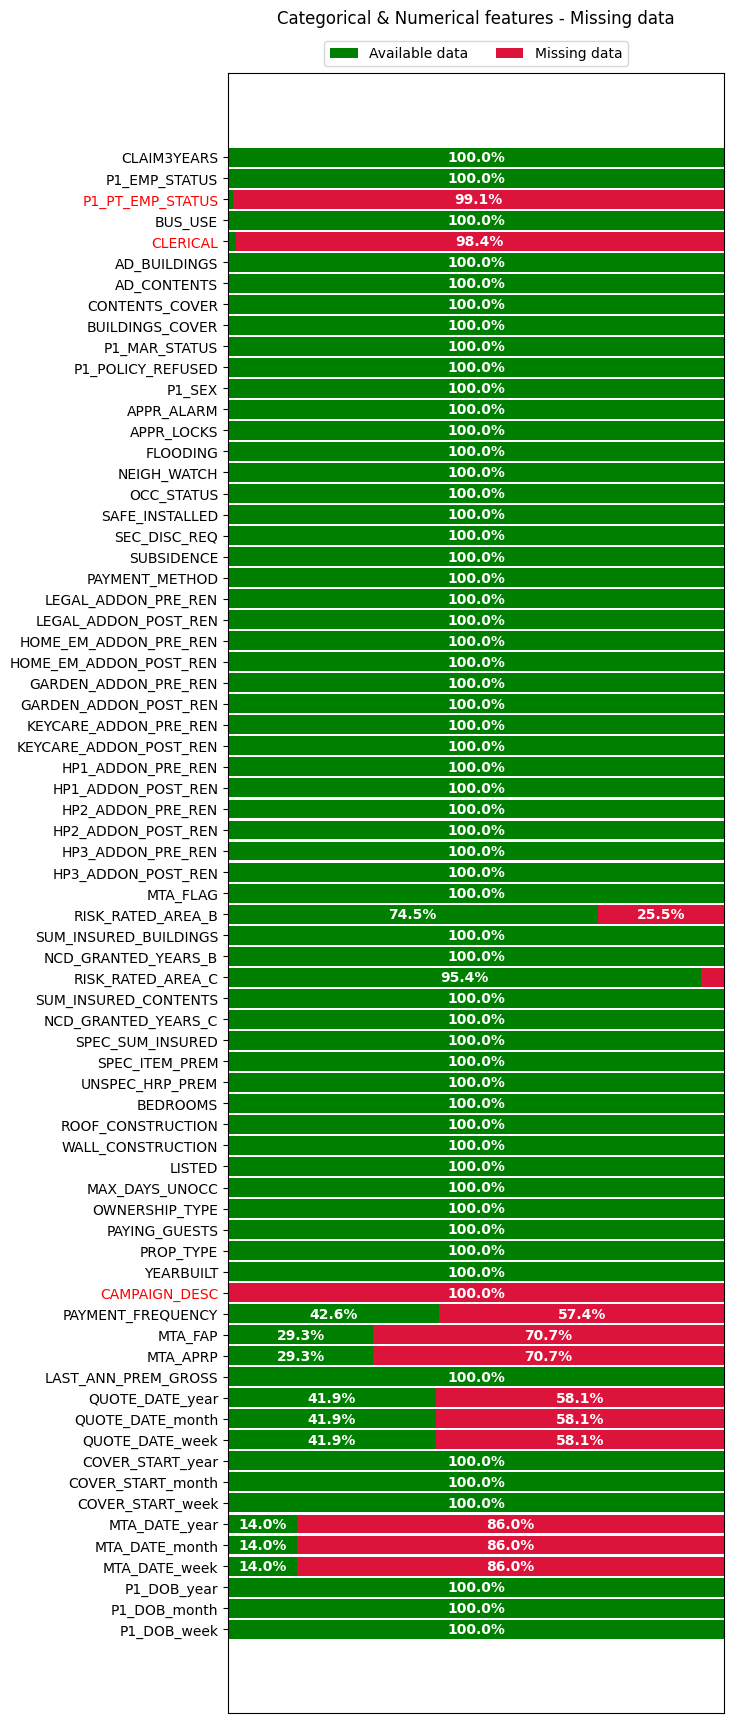

The following features have a proportion of missing data above the selected threshold (90.0%) 

P1_PT_EMP_STATUS
CLERICAL
CAMPAIGN_DESC


In [22]:
# Plotting results via custom function
bar_figure(df, EDA_config)

In [23]:
# Get the list of columns to be kept and to be pruned
missing = (df.isna()).astype(int).sum(axis=0)/df.shape[0]
keep_cols= [*missing[missing<EDA_config["threshold"]["missing_thres"]].index]
remove_cols = set(missing.index) - set(keep_cols)

In [24]:
# Updating the dataframe and EDA config 
df = df[keep_cols]
EDA_config["cat_features"] = [column for column in EDA_config["cat_features"] if column not in remove_cols]
EDA_config["num_features"] = [column for column in EDA_config["num_features"] if column not in remove_cols]

### Assessing the skew of missing data compared with the target variable
The availability of data can also be reflected in proportions for each class of the target variable 

In [25]:
# Adding a new arbitrary threshold to EDA config to highlight
# features with high proportion of missing data
EDA_config["threshold"]["missing_thres_diff"] = 0.1
EDA_config["target"] = target

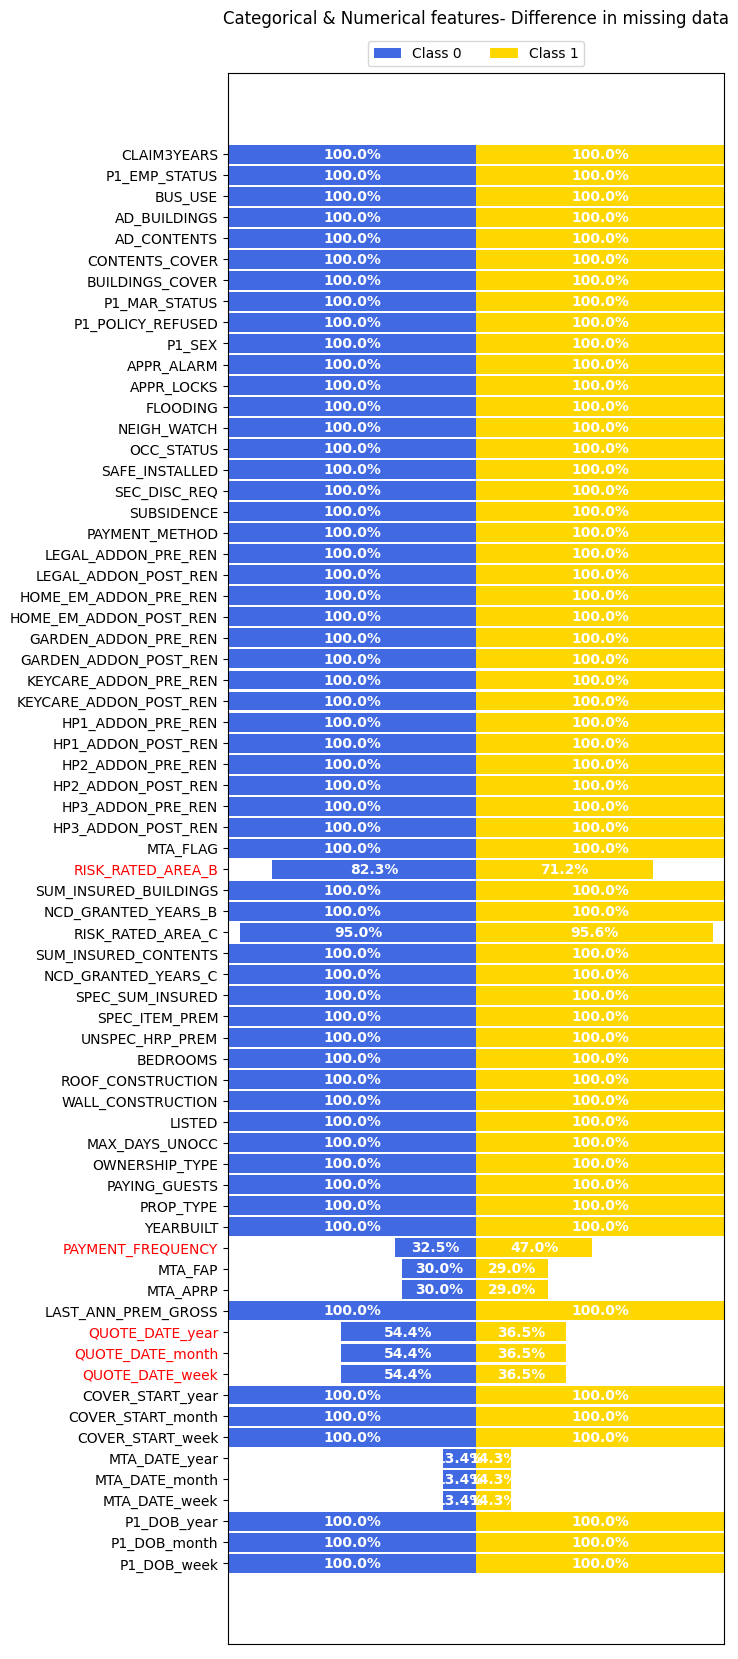

The following features have a difference in proportion of missing data between class 0/1 above the selected threshold (10.0%) 

RISK_RATED_AREA_B
PAYMENT_FREQUENCY
QUOTE_DATE_year
QUOTE_DATE_month
QUOTE_DATE_week


In [26]:
bar_diff_figure(df, EDA_config)

The proportions of missing data for each class in the target variable are largely similar for all features. Whilst some feature passed the chosen threshold, this threshold was quite low (10%), so no action to remove features is needed. 

##  d) Inspecting the distributions of each feature
The distributions of features can help determine preprocessing methods, specifically:
- imputation
- encoding
- outlier handling
which can then inform the appropriate choice of predictive model

### Numerical features - frequency distributions

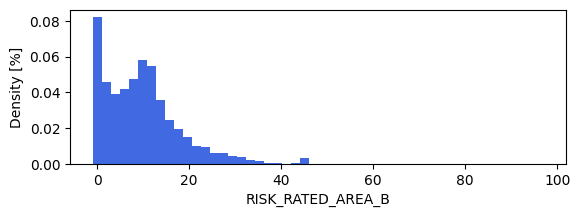

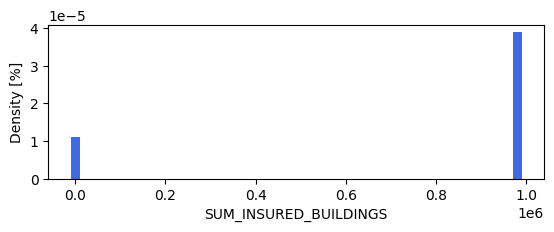

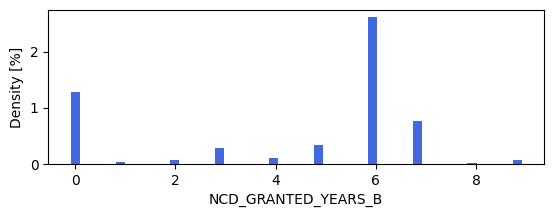

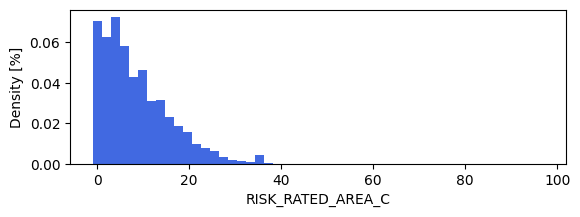

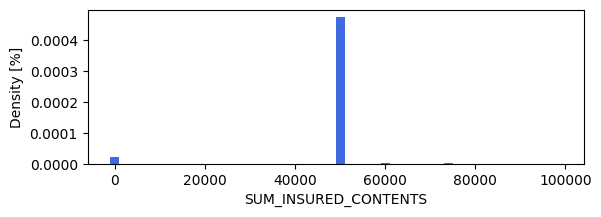

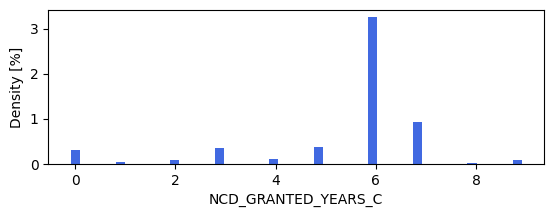

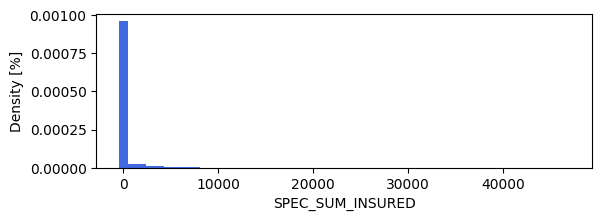

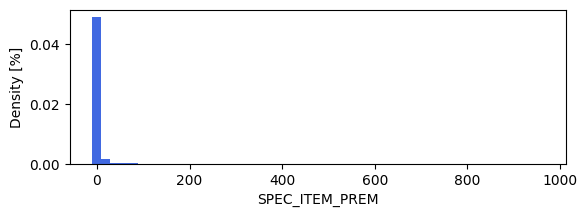

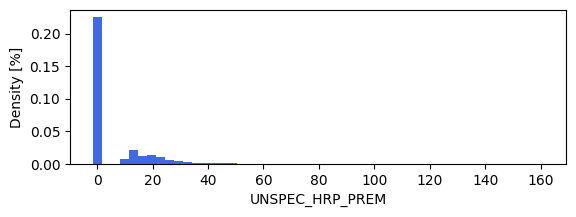

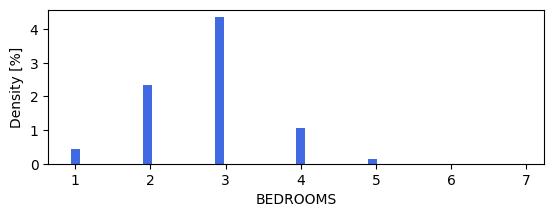

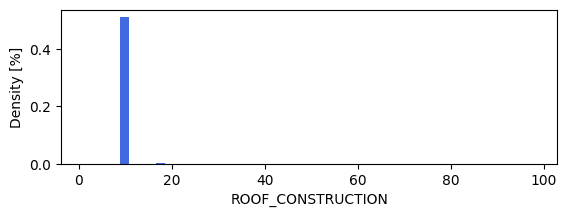

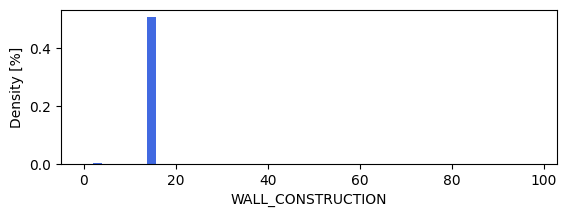

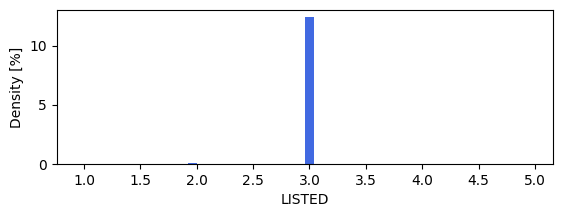

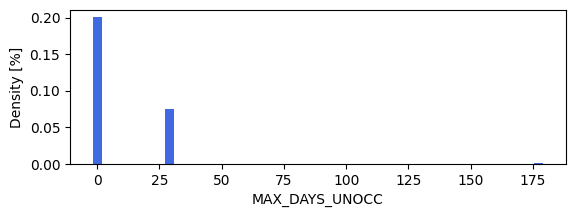

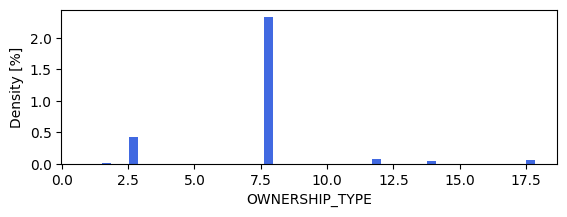

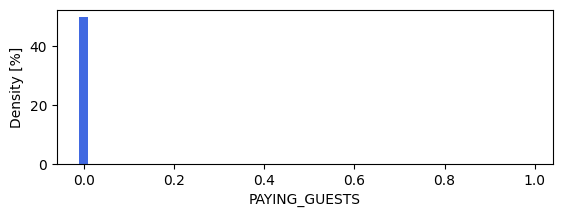

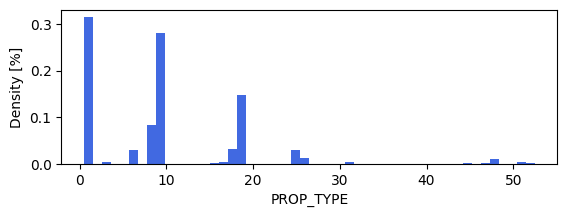

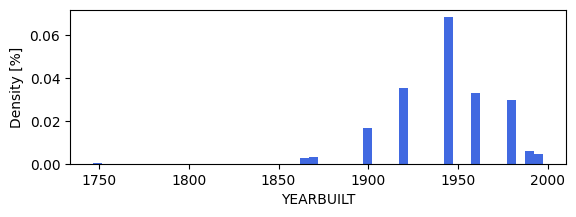

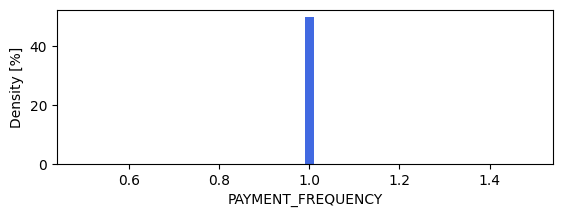

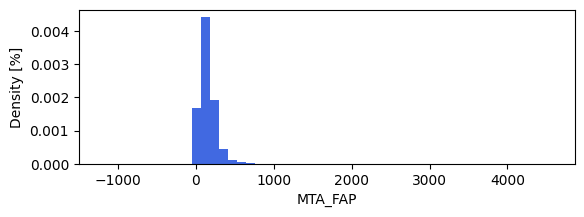

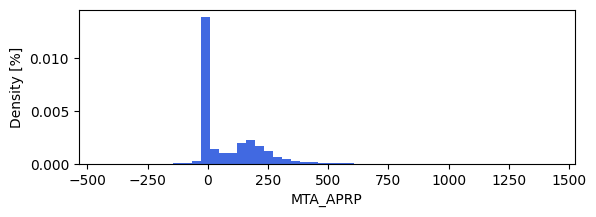

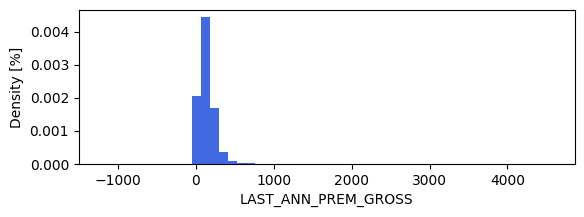

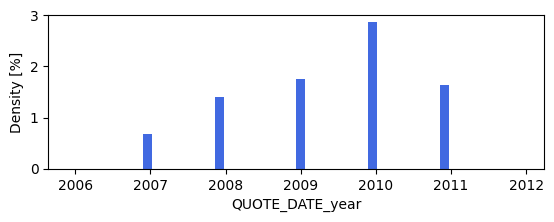

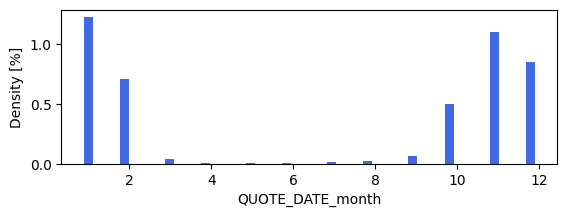

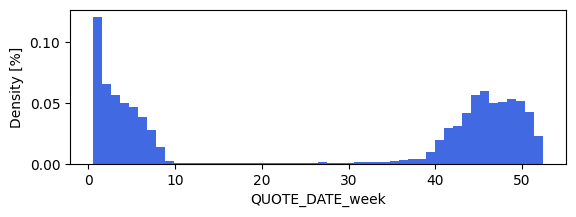

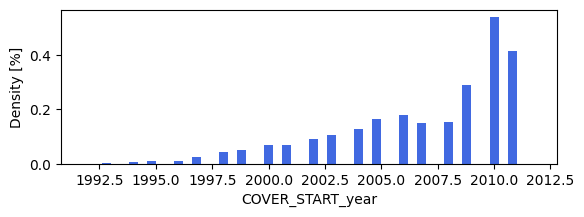

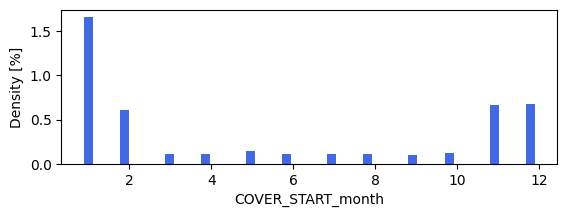

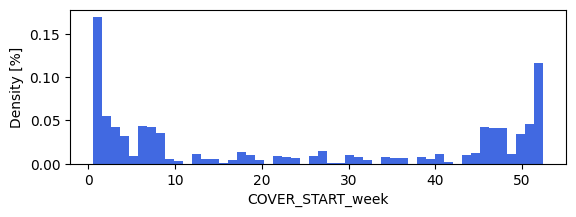

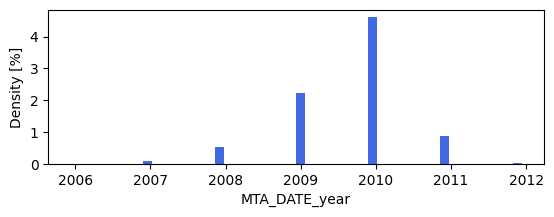

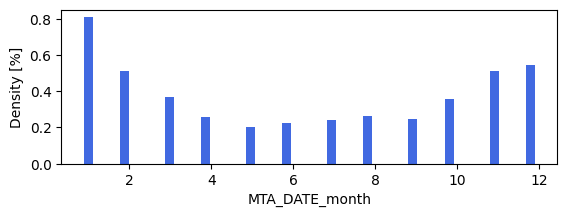

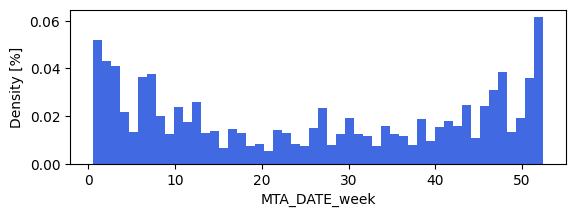

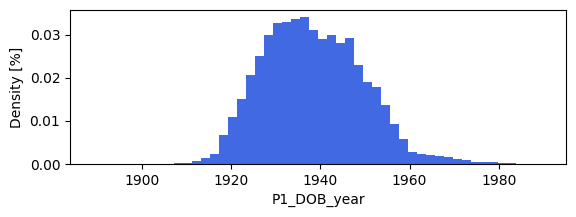

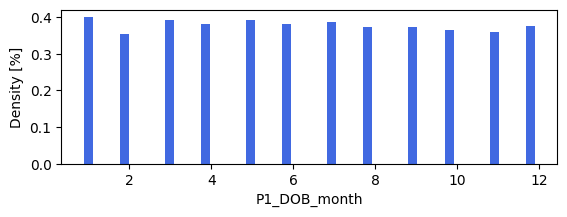

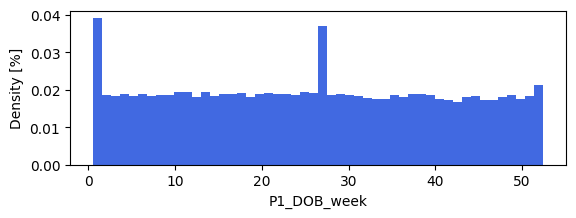

In [27]:
for feature in EDA_config["num_features"]:
    plot_dist(df, feature, "{} distribution".format(feature))

The distributions of our numerical features are very interesting. The majority of feature follow distributions which are intuitive to the information they are describing, e.g:
- "P1_DOB_year" is a proxy to "age", which would expect a relatively symmetric distribution, as with "YEARBUILT"
- "COVER_START_year" sees increases in opened policies closer to the date of data acquisition 
- "COVER_START_month" sees increases of opened policy towards the start and end of each year
- NO_OF_BEDROOMS follows a pattern that is expected, with small, medium and large housholds in the dataset
- many features have spikes at 0, where data seems to have been pre-imputed when no signal was found for the relevant policy.
---
Inspecting the numerical features which we created from date columns, i.e. those with "_year", "_month" and "_week" suffixes we see the following observations:
- "_week" features are simply more granular versions of their "_month" counterpart
- "P1_DOB_week" displays uncharacteristic spikes at start and middle of year - as if more people are born during these times. This is a data artifact which recommends removing the feature.
- Similarly erratic distributions are seen for other "_week" features. The data is aliased but captured via "_month" features, so all "_week" features will be removed
---

In [28]:
potentially_redundant_numeric_features = [
    "ROOF_CONSTRUCTION",
    "WALL_CONSTRUCTION",
    "LISTED",
    "PAYING_GUESTS",
    "PAYMENT_FREQUENCY"
]
for feature in potentially_redundant_numeric_features:
    print(feature, ": value count density\n")
    print(df[feature].value_counts(normalize=True) * 100, "\n\n")

ROOF_CONSTRUCTION : value count density

11.0    99.375149
19.0     0.353959
4.0      0.083067
2.0      0.051321
7.0      0.044972
15.0     0.025925
5.0      0.019576
10.0     0.013227
9.0      0.006878
3.0      0.005820
99.0     0.005820
16.0     0.005291
8.0      0.003704
14.0     0.003704
12.0     0.000529
18.0     0.000529
6.0      0.000529
Name: ROOF_CONSTRUCTION, dtype: float64 


WALL_CONSTRUCTION : value count density

15.0    99.494722
3.0      0.196291
19.0     0.081479
16.0     0.041798
14.0     0.040211
5.0      0.033862
11.0     0.027512
4.0      0.018518
18.0     0.015344
20.0     0.013227
9.0      0.010582
2.0      0.005820
21.0     0.005291
99.0     0.005291
23.0     0.004762
22.0     0.002116
12.0     0.001587
1.0      0.001058
6.0      0.000529
Name: WALL_CONSTRUCTION, dtype: float64 


LISTED : value count density

3.0    99.424354
2.0     0.493638
4.0     0.039681
5.0     0.026454
1.0     0.015873
Name: LISTED, dtype: float64 


PAYING_GUESTS : value count density



Whilst each of the above features have highly skewed distributions, the data may still provide useful signals for discriminating between lapsed and live policies.

Contextually, it should be noted that "PAYMENT_FREQUENCY" on insurance policies can often indicate the type of payment, and therefore the type of "renewal opportunity". Whilst the provided feature definition has been limited to "Frequency of payment", it can be inferred that these all home policies in the dataset comprise annual payments, instead of monthly payments (PAYMENT_FREQUENCY = 12). These latter type of policies, e.g. health insurance, are often paid via Direct Debits depsite having annual contracts to offer customers the opportunity to renew or lapse. For some monthly payment policies, customers may be retained as "auto-renew" customers.

In our current task, the aim is to select an appropriate customer base to target to reduce future lapsed cases, which could be achieved via marketing. However, with auto-renew customers, there is also the consideration that marketing to customers with high propensity to lapse may "awake" them to assess their policy, and then actually lapse. Fortunately, in our data:
- since our payments are annual, we can assume one-off payments with no auto-renew Direct Debit
- since all customers have the same payment type, they can be treated equally for contact eligibility. Nonetheless we can remove the "PAYMENT_FREQUENCY".


In [29]:
# Updated the dataframe and EDA config
drop_cols = [feature for feature in EDA_config["num_features"] if "_week" in feature] + ["PAYMENT_FREQUENCY"]
df.drop(drop_cols, axis = 1, inplace=True)

feature_types = get_feature_types(df.drop(target, axis = 1))
EDA_config["cat_features"] = feature_types["categorical"]
EDA_config["num_features"] = feature_types["numeric"]

### Numerical features - boxplots for outlier discovery

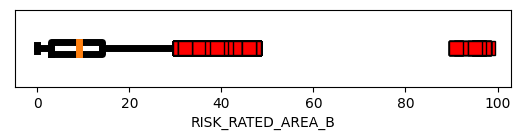

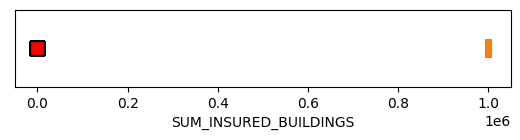

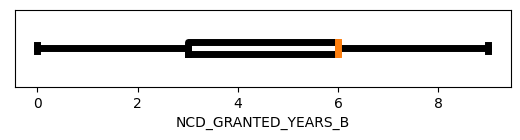

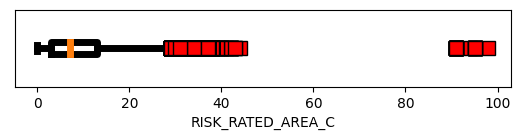

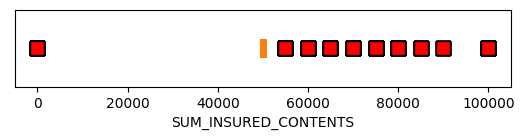

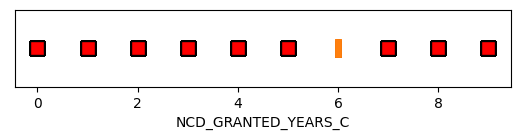

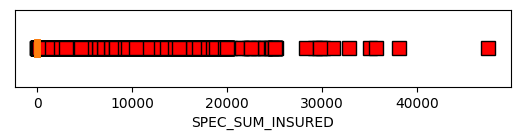

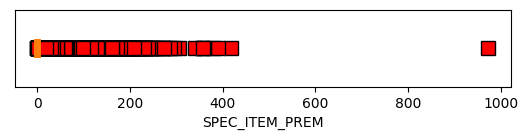

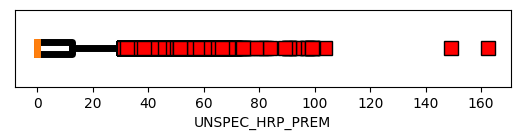

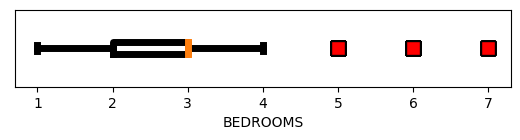

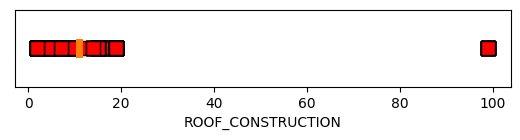

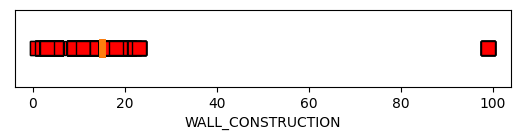

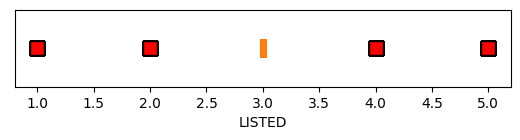

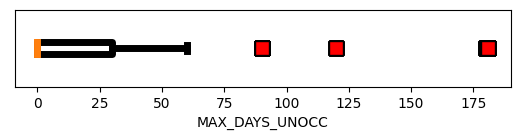

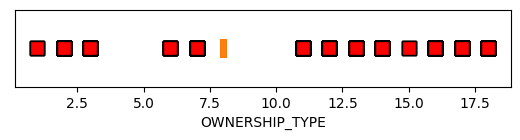

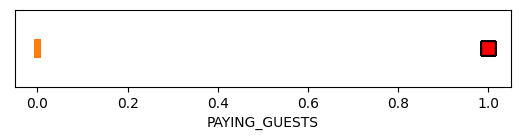

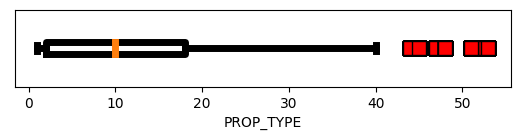

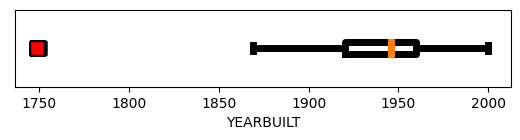

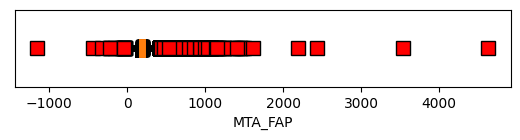

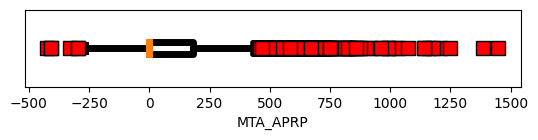

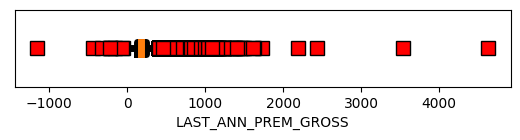

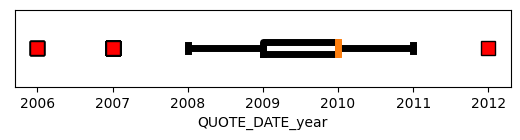

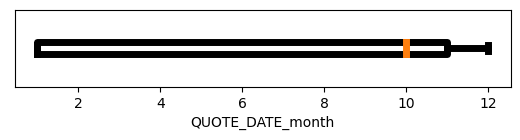

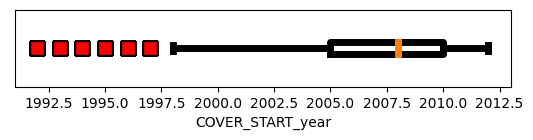

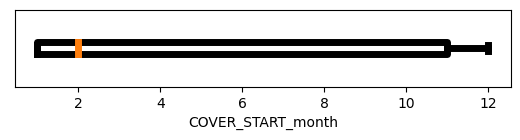

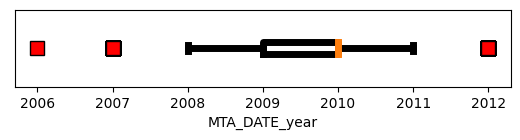

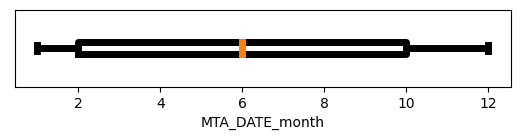

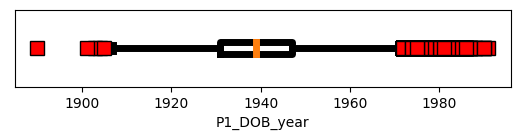

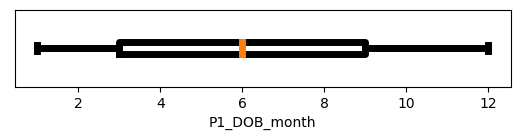

In [30]:
for feature in EDA_config["num_features"]:
    plot_box(df, feature, "{} box_plot".format(feature))

The density distributions alluded to some highly skewed numerical features, which are further shown by the box plots above. We see many features, such as RISK_RATED_AREA_B, RISK_RATED_AREA_C, SPEC_ITEM_PREM, MTA_DATE_year, YEARBUILT contain outliers.

It is often difficult to determine a standardised approach to outliers, which also captures bespoke nuances in each feature. 
Some features more simple than others, e.g. YEARBUILT outlier with house built in 1750 could be easily removed.

To account for standardisation and time constraints, no outlier treatment was opted for - instead decisions where made to model via methods which are more robust to outliers, namely tree-based methods.

### Categorical features - proportion of each category

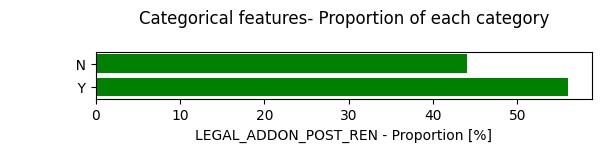

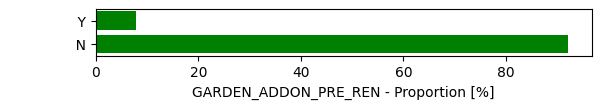

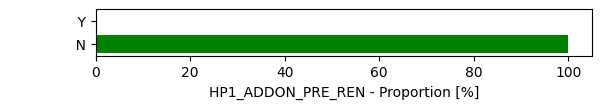

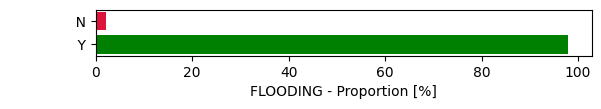

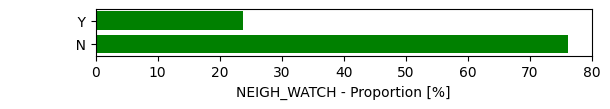

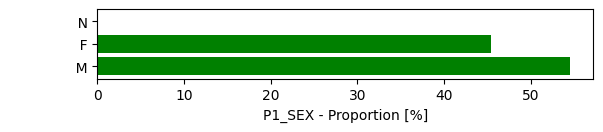

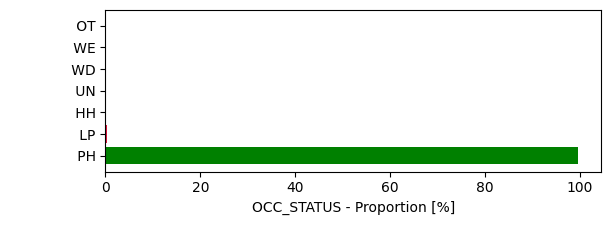

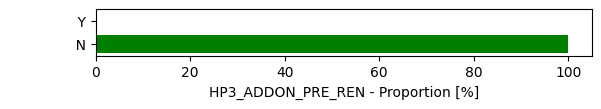

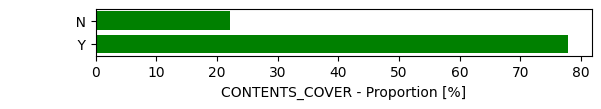

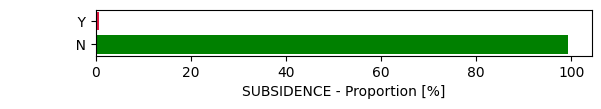

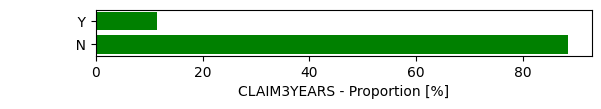

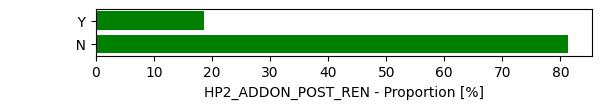

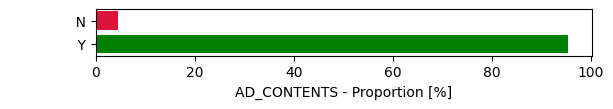

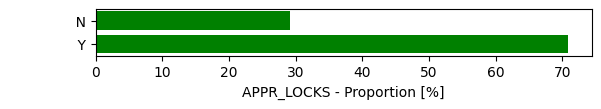

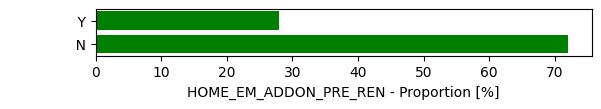

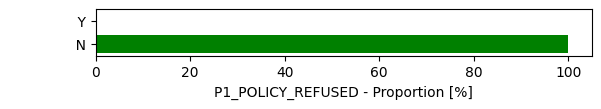

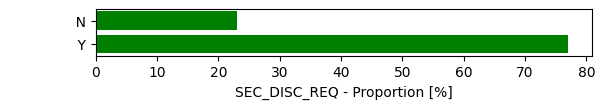

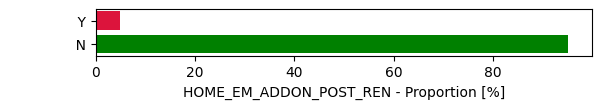

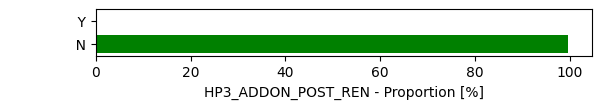

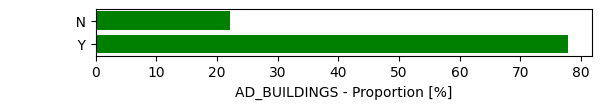

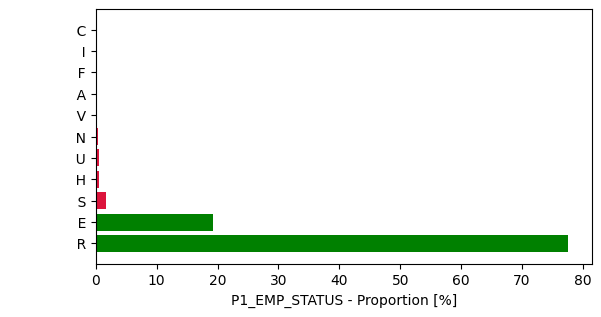

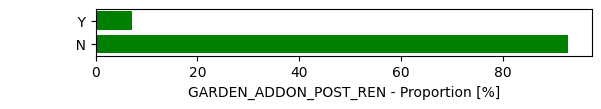

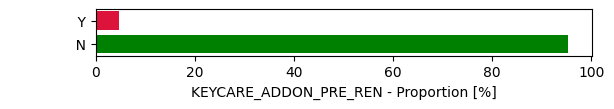

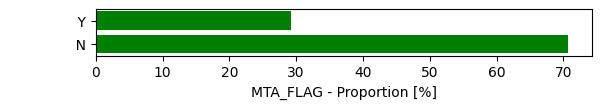

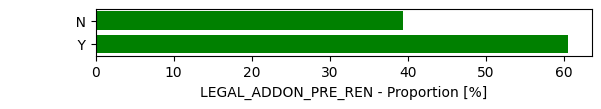

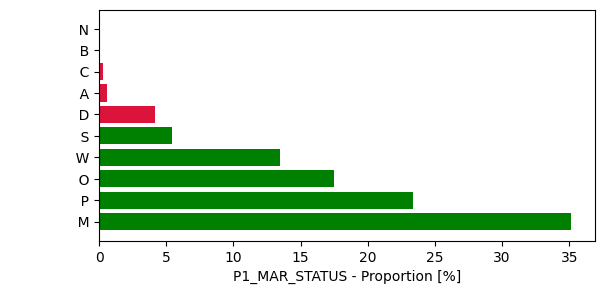

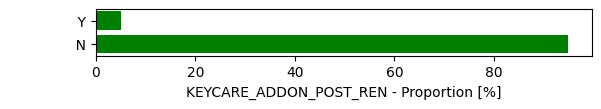

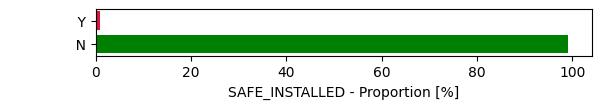

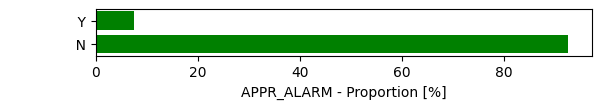

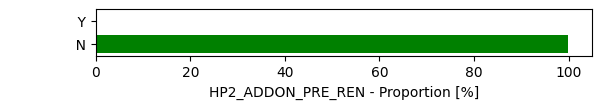

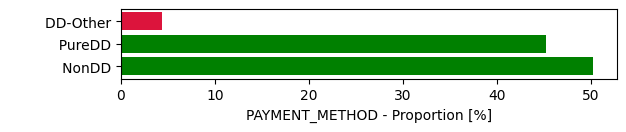

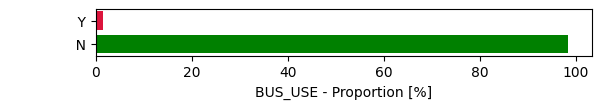

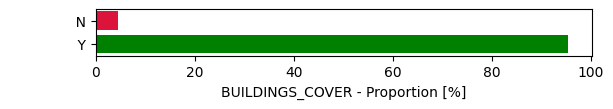

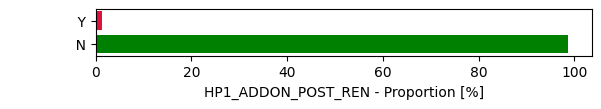

The following categorical features have at least one category with volume lower than the selected threshold (5% of total or less
HP1_ADDON_PRE_REN
FLOODING
P1_SEX
OCC_STATUS
HP3_ADDON_PRE_REN
SUBSIDENCE
AD_CONTENTS
P1_POLICY_REFUSED
HOME_EM_ADDON_POST_REN
HP3_ADDON_POST_REN
P1_EMP_STATUS
KEYCARE_ADDON_PRE_REN
P1_MAR_STATUS
SAFE_INSTALLED
HP2_ADDON_PRE_REN
PAYMENT_METHOD
BUS_USE
BUILDINGS_COVER
HP1_ADDON_POST_REN


In [31]:
EDA_config['threshold']['low_cat_thres_per'] = 5
plot_cat_bar(df, EDA_config, len(df), bad_cat_features)

Similarly to outliers in numerical features, a significant number of categorical features contain scarce categories.

Again, to account for standardisation and time constraints, no immediate cardinality limits were applied - instead decisions where made to model via methods which are more robust to sparsity, namely tree-based methods.

# Modelling

Now that we have explored and optimised our input data, we can look to wards predictive modelling.

Since we have a binary target variable "lapse" or "not lapse" (live policy) we look to choose a discriminitive supervised learning algorithm. For this task, we use classification methods, but aim to predict our binary outcomes with a certain "confidence", i.e. probability.  

Based on our findings and decisions, we have opted for tree-based methods, which could include (but no limited to):
- RandomForest Classifier
- XGBoost Classifer


Random Forest Classifiers are ensemble tree-based methods which employs "bagging", whereby mutliple Decision trees a fit on a subset of the data and features, bootstrapped and predictions are made, before a aggregated prediction is taken from each tree. 
XGBoost, on the other hand, is an ensemble tree-based method which employs "boosting", a technique to fit each tree based on residulas from the former tree's predictions on a subset of features. 

Given time constraints, we have opted to only model via XGBoost, but to optimise the model through hyperparameter tuning.
XGBoost was chosen for several reasons:
- Performance
- Faster training (gradient boosting)
- In-built regularisation
- Explainability functions (despite inherent algorithm complexity)
- Handling of imbalanced data

### Train-test split
Here we split only into a training and test set, since the training set will be cross-validated upon.
We choose a split of 80% training data, 20% test data and later, 4-fold cross validation, mimicking an overall 60:20:20 split

In [32]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1337)

In [33]:
train_X = train_df.drop(target, axis = 1)
train_y = train_df[target]

test_X = test_df.drop(target, axis = 1)
test_y = test_df[target]

### One-hot encoding of categorical variables

In [34]:
categorical_features = list(train_X.dtypes[df.dtypes == 'object'].index)
dummy_values = select_dummy_values(train_X,
                                   categorical_features)

In [35]:
dummy_encode_dataframe(train_X, dummy_values)
dummy_encode_dataframe(test_X, dummy_values)

### Accounting for imbalanced classes
Policy lapse, i.e. target == 1, is less common than renewal. To account for this, we must ensure out model biases towards the minority class to "equal the playing field" for predictions. We do this using the "scale_pos_weight" parameter for XGBoost.

It is important to note that "probability" predictions from many ML models are in fact simply normalised comparitive predictions based on the set of input data. This is often why unseen "test" data can display a different distribution than training data - especially when a model is overfit.
In this way, we can our weighting for the minority class let's us use an intuitive threshold for "lapse probability", i.e. proba > 0.5 indicating that a customer is more likely to lapse than renew *compared to other customers*  

In [36]:
# Actual proportion of classes
test_y.value_counts() / test_y.count() * 100

0    69.680696
1    30.319304
Name: POL_STATUS, dtype: float64

In [37]:
# Setting the scale_pos_weight parameter based on the ratio majority class:minority class
scale_pos_weight = test_y.value_counts()[0] / test_y.value_counts()[1]
scale_pos_weight

2.29822877584853

The above value has been hard-coded into the model parameters

### Loading XGBoost parameters and building a hyperparameter space for optimisation
Here we use a simple and GridSearch to optimise our model based on a chosen hyperparameter space. HalfGridSearch could also be used, as well as more modern techniques for optimisation

In [38]:
# XGBoost model object loaded with defaulted parameters loaded from custom module
XGB_Model = xgb_model_paras_feature_sel

# Set a hyperparameter space which is large enough for several jobs but not too computationally or
# temporally expensive
param_grid = {
  "n_estimators": [100, 200, 300],
  "learning_rate": [0.3, 0.4, 0.5],
  "max_depth": [3, 4, 5],
}

# Instantiate a Gridsearch object
grid_search = GridSearchCV(
    xgb_model_paras_feature_sel,
    param_grid,
    cv=4,
    verbose=3,
    refit="auc",
    scoring="f1_weighted",
)

### Tuning the model and saving model artifacts
The following code has been commented out to avoid re-tuning a model which has already been saved.

In [52]:
"""
# Fit / Tune for given parameters
grid_search.fit(train_X, train_y)

# Save the model artifacts
xgb_model = grid_search.best_estimator_.fit(train_X, train_y)
xgb_model_pkle = pickle.dump(xgb_model, open("models/xgb_model",'wb'))

xgb_model_features = list(train_X.columns)
xgb_model_features_pkle = pickle.dump(xgb_model_features, open("models/xgb_model_features",'wb'))

xgb_model_dummy_values = dummy_values
xgb_model_features_pkle = pickle.dump(xgb_model_dummy_values, open("models/xgb_model_dummy_values",'wb'))
"""

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV 1/4] END learning_rate=0.3, max_depth=3, n_estimators=100;, score=0.711 total time=   8.6s
[CV 2/4] END learning_rate=0.3, max_depth=3, n_estimators=100;, score=0.711 total time=   8.5s
[CV 3/4] END learning_rate=0.3, max_depth=3, n_estimators=100;, score=0.707 total time=   8.4s
[CV 4/4] END learning_rate=0.3, max_depth=3, n_estimators=100;, score=0.705 total time=   8.6s
[CV 1/4] END learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.715 total time=  17.0s
[CV 2/4] END learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.714 total time=  16.8s
[CV 3/4] END learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.708 total time=  17.2s
[CV 4/4] END learning_rate=0.3, max_depth=3, n_estimators=200;, score=0.708 total time=  17.3s
[CV 1/4] END learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.717 total time=  26.0s
[CV 2/4] END learning_rate=0.3, max_depth=3, n_estimators=300;, score=0.716 total t

[CV 3/4] END learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.709 total time=  10.5s
[CV 4/4] END learning_rate=0.5, max_depth=4, n_estimators=100;, score=0.709 total time=  10.5s
[CV 1/4] END learning_rate=0.5, max_depth=4, n_estimators=200;, score=0.716 total time=  20.4s
[CV 2/4] END learning_rate=0.5, max_depth=4, n_estimators=200;, score=0.716 total time=  20.4s
[CV 3/4] END learning_rate=0.5, max_depth=4, n_estimators=200;, score=0.711 total time=  20.9s
[CV 4/4] END learning_rate=0.5, max_depth=4, n_estimators=200;, score=0.711 total time=  20.2s
[CV 1/4] END learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.714 total time=  30.1s
[CV 2/4] END learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.714 total time=  30.3s
[CV 3/4] END learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.712 total time=  30.2s
[CV 4/4] END learning_rate=0.5, max_depth=4, n_estimators=300;, score=0.712 total time=  30.3s
[CV 1/4] END learning_rate=0.5, max_depth=5, n_est

In [78]:
grid_search.best_estimator_

XGBClassifier(cv=4, eval_metric='auc', learning_rate=0.3, max_depth=5,
              n_estimators=300, n_jobs=16, random_state=1337,
              scale_pos_weight=2.3, subsample=1.0, verbose=3)

# Model evaluation (using test set)

### Load in the model artifacts

In [39]:
loaded_model = pickle.load(open("models/xgb_model",'rb'))
loaded_features = pickle.load(open("models/xgb_model_features",'rb'))
loaded_dummy_values = pickle.load(open("models/xgb_model_dummy_values",'rb'))

### Build predictions and stitch back to each policy

In [40]:
predictions = loaded_model.predict(test_X)
results = result_build(loaded_model, test_X, test_y, df_index_cols)
results

,i,Police,0,1,predicted_value,target
4,5,P000005,0.567106,0.432894,0,0
24,25,P000025,0.737215,0.262785,0,0
25,26,P000026,0.745927,0.254073,0,0
31,32,P000032,0.651274,0.348726,0,0
32,33,P000033,0.719794,0.280206,0,0
...,...,...,...,...,...,...
256110,256111,P256111,0.310596,0.689404,1,0
256116,256117,P256117,0.803735,0.196265,0,1
256120,256121,P256121,0.686629,0.313371,0,0
256126,256127,P256127,0.740511,0.259489,0,0


### Examine performance

#### F1_score, recall, precision

In [41]:
model_metrics = performance_metric(results, loaded_model)
model_metrics

,product,f_score,recall,precision
0,0,0.78,0.75,0.82
1,1,0.57,0.63,0.52


#### Confusion matrix

In [42]:
cm = get_confusion_matrix(test_y, predictions, loaded_model)
cm

Actual,0,1
Predicted,,
0,19703,6637
1,4211,7250


#### Distributions

In [43]:
probability_distributions = get_distributions(cm)
probability_distributions

,class,model,actual
0,0,0.632629,0.696807
1,1,0.367371,0.303193


#### AUC-ROC

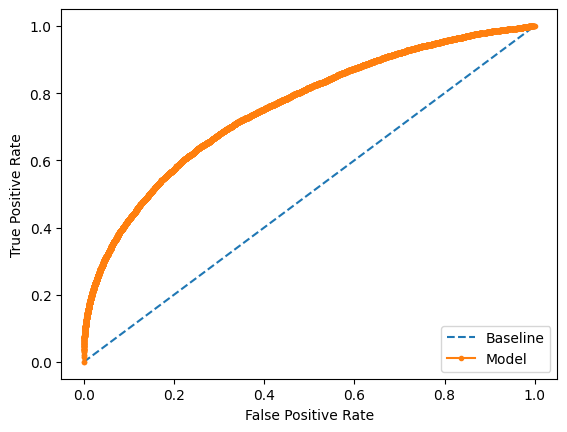

In [44]:
# Plot the AUD_ROC curve via a custom function
auc_plot(test_X, test_y, loaded_model)

#### Probability distribution

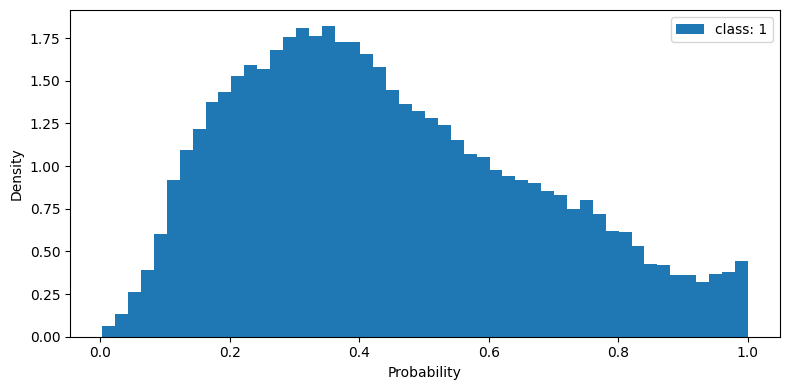

In [45]:
# Plot the probability distribution via a custom function
ProbaDist.plot_predictions_distribution(pd.DataFrame(results[1]))

#### Cumulative Gains (expected uplift) chart 

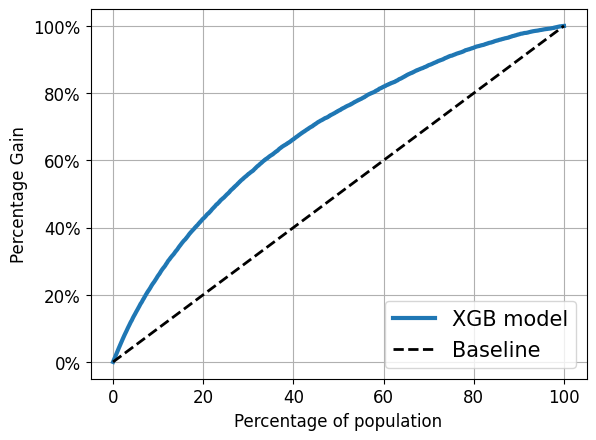

In [46]:
# Plot the uplift chart via a custom function
UpliftChart.plot_cumulative_gain([results["target"]], [results[[0, 1]]], ["XGB model"])

The F1 score and AUC-ROC curve indicate that our model performs better than a baseline model.

The probability distributions align with class proportions. We see that class: 1, i.e. lapse, has a right-skewed distribution with more policies predicted for renewal than lapse, as expected

The cumulative gains chart also expresses the expected uplift by marketing to a selected audience. This is particularly useful in teh business context, where:
- it is unwise to target all customers with marketing communications
- it can be costly to send targeted marketing communications
- a balance must be struck between cost of marketing, volume of target audience and uplift in policy retention.

The cumulative gains chart can help choose a percentile threshold above which customers may be eligbile for target comms. In this case, selecting the top 50% of lapse propensities would capture 75% of actual lapses.

If we propagate our dataset to a more realistic volumne of policies / customer base, we can choose an arbitray threshold in favour of low volume for a phase 1 batch of targeted communications. We will choose the top 25% of customers, which will capture 50% of lapses. This will be our challenger group...

### Test design
If we were predicting policy purchase, it is more simple - we could happily send a marketing email which advertises a product to a customer with high propensity to buy.

However, The inherent nature of policy lapse makes designing a real-life test for our model difficult. As mentioned earlier, some customers can be "awoken" by marketing comms, which may cause them to lapse. Therefore we should design a test which measures both:
- efficacy of the model
- efficacy of the marketing comm

Based on our findings from the cumulative gains chart, we could design the following test:
- top 25% propensity customers -> randomly split into two buckets:
    - 20% challenger group
    - 5% challenger holdout group (fallow cell)
- bottom 25% propensity customers -> randomly split into two buckets:
    - 20% control group
    - 5% control holdout group (fallow cell)
    
By selecting more customers in challenger and control groups, we can emphasies importance of measure our model's performance in phase 1 of the test. 
Using live business results, i.e. retention rates over a period N months after go-live date, we can compare each test group's performance. When measuring performance, we would need to scale up retention volumes (or use retention rates) for each holdout group for:
- a) significant results
- b) robust comparison between groups.
Furthermore, the test groups can be adjusted as time goes by 

### Feature importance
Another useful tool for marketing stakeholders is to deliver a list of features, i.e. signals which are highly predictive of policy lapse. A feature importance graph increases the level of explainability, especially when using complext ML models like XGBoost. here, we are most intersted in comparative importance of each feature as opposed to the raw values 

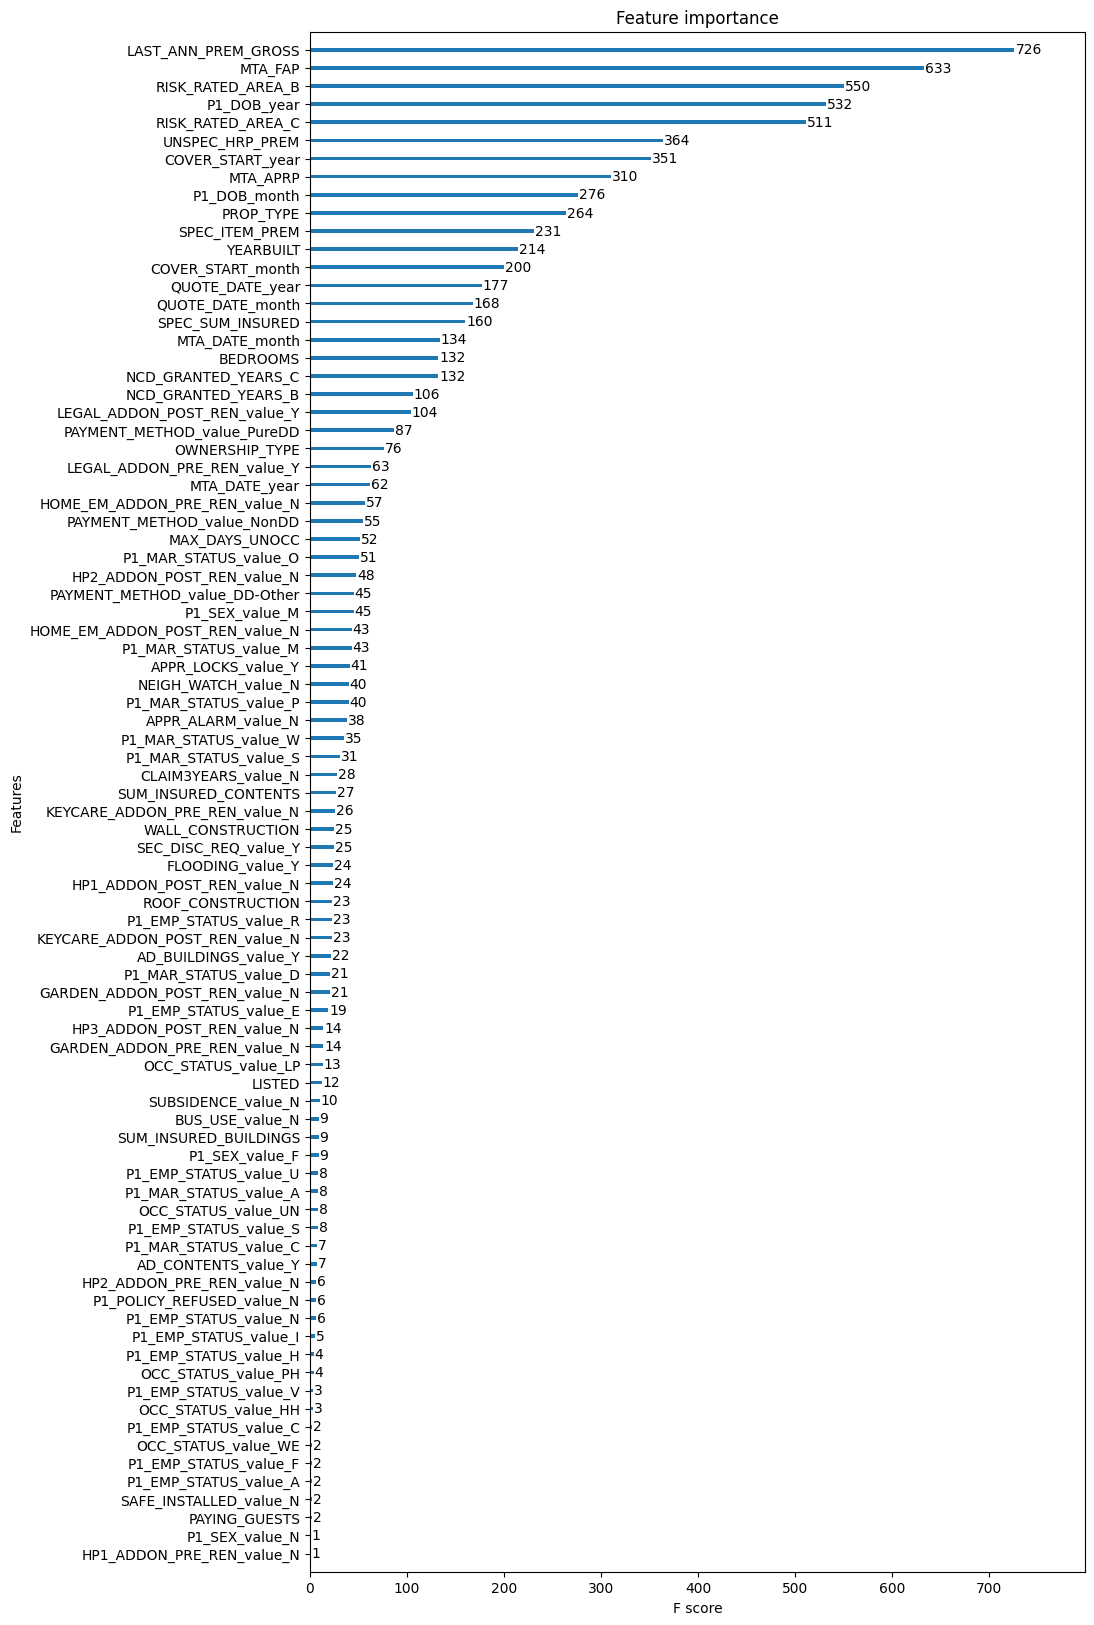

In [47]:
# Plot the comparative feature importance via a custom function
FeatureImportance.plot_feature_importance(loaded_model, loaded_features)

# Model scoring and final audience selection

In [48]:
# Get features and target for all policies
X = df.drop(target, axis = 1)
y = df[target]

In [49]:
# One-hot encode categorical features
dummy_encode_dataframe(X, loaded_dummy_values)

In [50]:
# Get prediction results
scoring_results = result_build(loaded_model, X, y, df_index_cols)

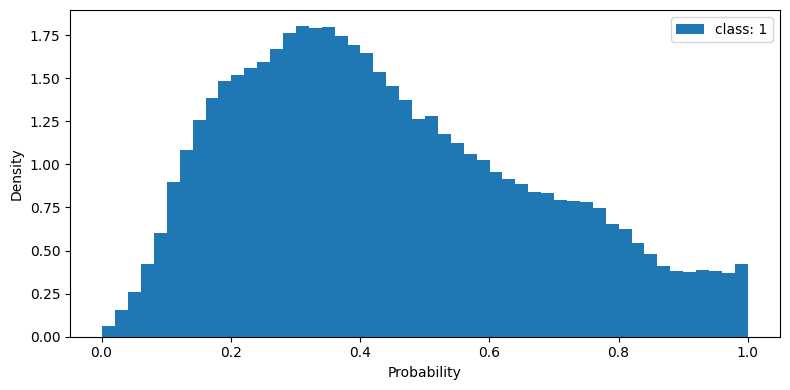

In [51]:
# Plot the probability distribution via a custom function
ProbaDist.plot_predictions_distribution(pd.DataFrame(scoring_results[1]))

When scoring on all policies, we see a very similar probability distribution to the test set 

In [52]:
# Reformat the predictions for only "lapse" class
final_scores_df = scoring_results[[*index_cols, 1]]
final_scores_df = final_scores_df.rename({1:"lapse_probability"}, axis = 1)

In [53]:
# Add percentiles
final_scores_df['percentile'] = (final_scores_df.lapse_probability.rank(pct = True) * 100).astype(int)

In [54]:
# Keep top25 and bottom25 percentile scores
top25 = (
    final_scores_df[final_scores_df["percentile"]>74]
    .sort_values("percentile", ascending = False)
)

bottom25 = (
    final_scores_df[final_scores_df["percentile"]<24]
    .sort_values("percentile", ascending = False)
)

In [55]:
# Generate test groups
challenger_holdout = top25.sample(frac=0.2)
control_holdout = bottom25.sample(frac=0.2)
challenger = top25.loc[set(top25.index) - set(challenger_holdout.index)]
control = bottom25.loc[set(bottom25.index) - set(control_holdout.index)]

challenger_holdout["group"] = "challenger_holdout"
control_holdout["group"] = "control_holdout"
challenger["group"] = "challenger"
control["group"] = "control"

In [56]:
# Join test groups into a final audience
final_audience = pd.concat([
    challenger_holdout,
    control_holdout,
    challenger,
    control], axis = 0)

In [57]:
final_audience

,i,Police,lapse_probability,percentile,group
110074,110075,P110075,0.710812,84,challenger_holdout
119687,119688,P119688,0.803706,91,challenger_holdout
147898,147899,P147899,0.906004,96,challenger_holdout
199937,199938,P199938,0.632147,77,challenger_holdout
84023,84024,P084024,0.683659,82,challenger_holdout
...,...,...,...,...,...
131022,131023,P131023,0.134571,6,control
131056,131057,P131057,0.235160,20,control
131058,131059,P131059,0.102298,3,control
131061,131062,P131062,0.093526,2,control


Our final dataset contains approximately 90000 policies (customers) for the test, split into the following groups:
- challenger (40%)
- control (40%)
- challenger_holdout (10%)
- control_holdout (10%)